# Introduction to Convolutional Neural Networks with Keras 

### The data set used: CIFAR10
[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) is a data set with 60000 labeled images. 10000 are reserved to test.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Input, Dense, MaxPooling2D, Flatten, Conv2D, ZeroPadding2D, BatchNormalization, Activation
from keras.datasets import cifar10
from keras import optimizers, losses
from keras.models import Model
import keras.utils
from keras.utils import to_categorical
from keras import utils as np_utils
from keras.models import model_from_json
import time
%matplotlib inline

Using TensorFlow backend.


In [2]:
#load the data, we won't use now the test set
(x_train, y_train), ( x_test , y_test) = cifar10.load_data() #the _ indicates we don't want that value

## Understanding the data_set
The training set has 50000 images RGB each of shape 32x32x3 (x_train) and 5000 labels (y_train). 
The test set has 1000 images with the same especifications.
0. airplane 										
1. automobile 										
2. bird 										
3. cat 										
4. deer 										
5. dog 										
6. frog 										
7. horse 										
8. ship 										
9. truck 										
 

In [3]:
#Dividing the training set into test set and validation set
x_validation = x_train[45000:50000]
y_validation = y_train[45000: 50000]
x_train = x_train[0:45000]
y_train = y_train[0: 45000]

In [ ]:
#Extracting sizes
m = x_train.shape[0]
width =  x_train.shape[2] #the width is the number of columns
height = x_train.shape[1] #the height is the number of lines
n_C = x_train.shape[3]

#View the data
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
index = np.random.randint(m)
img = x_train[index]
print("label: ", y_train[index], classes[int(y_train[index])])
imgplot = plt.imshow(img)

plt.figure(figsize=(32,32))
print ("x_train.shape = ", x_train.shape)
print("y_train.shape = ", y_train.shape)
print("x_validation.shape = ", x_validation.shape)
print("y_validation.shape = ", y_validation.shape)
print("x_test.shape = ", x_test.shape)
print("y_test.shape = ", y_test.shape)
print("number of classes: ", np.max(y_train) + 1)

## Keras Layers
[Conv2D](https://keras.io/layers/convolutional/)  
[MaxPooling2D](https://keas.io/layers/pooling/)
[Add](https://keras.io/layers/merge/): example of merging layers. Usefull to implement ResNet's. 

## first_model:
input => 16 filters of 3x3 stride 1, no padding => 1 POOL layer 2x2 stride 2 => 8 filters 5x5x16 stride 2 = Flatten =>FC 20 nodes => softmax() with 10 outputs. 
This model is simple, it's actually too small. That means it's hard to train. It has approximately 20000 parameters.

## happy_house:
A model based on a Deeplearning.ai tutorial.

## super_cool_model:
Implements the following architecture:  
CONV2D =>BN => RELU => CONV2D => MAXPOOLING => BN => RELU => CON2D => BN => FC =>SOFTMAX


In [5]:
def first_model(): 
    model = Sequential()
    #layer 1
    initializer = keras.initializers.he_normal(1)
    model.add(Conv2D(16, 3, strides = 1, input_shape = x_train[0].shape,
                     padding = 'valid', activation = 'relu', kernel_initializer = initializer))
    #layer 2
    model.add(MaxPooling2D(pool_size=(4, 4), strides=(2, 2)))
    #layer 3
    model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer = initializer))
    model.add(Flatten())
    #layer 4
    model.add(Dense(30, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [6]:
#PAD (3,3) -> CONV2D (7X7,32) -> BN -> RELU -> MAXPOOL (2,2) ->FLATTEN
#->SIGMOID
def HappyModel(input_shape):
    """
    Implementation of the HappyModel.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    X_input = Input(input_shape)
    #Zero-padding: pads the border of X_input with zeros
    X = ZeroPadding2D((3,3))(X_input)
    #CONV2D: uses 32 filters 7x7
    X = Conv2D(32,(7,7), strides = (1,1), name = 'conv0')(X)
    #BN
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    #RELU
    X = Activation('relu')(X)
    #MAXPOOL
    X = MaxPooling2D((2,2), name = 'max_pool')(X)
    
    #FLATTEN X (CONVERT TO VECTOR) -> fully connected layer
    X = Flatten()(X)
    X = Dense(10, activation='softmax', name ='fc')(X)
    
    #creates the model
    model = Model(inputs = X_input, outputs = X, name = 'HappyModel')
    ### END CODE HERE ###
    
    return model

In [15]:
def super_cool_model (input_shape):
    """
    Arguments: input_shape a tuple with the input shape
    Returns: a model (intance of Model in Keras) with a super cool architecture
    CONV2D =>BN => RELU => CONV2D => MAXPOOLING => BN => RELU => CON2D => BN => FC =>SOFTMAX
    """
    
    X_input = Input(input_shape)
    
    # if the iput shape is (32,32,3), is layer will have 4705 parameters (including bias)
    X = Conv2D(32, (7,7), strides = (1,1), padding = 'same', name = 'conv0', use_bias = True)(X_input)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)  # no parameters
    X = Activation('relu')(X)                       # no parameters
    
    # after the fisrt conv layer the volume is shape (32,32,32)
    # here we have more 51201 parameters including the bias
    X = Conv2D(64, (5,5), strides = (1,1), padding = 'same', name = 'conv1', use_bias = True)(X)
    
    # here the volume is shape (32, 32, 64)
    X = MaxPooling2D((2,2), strides = (2,2), name = 'max_pool')(X)
    
    # after the max pooling the volume is shape (16,16, 64)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X)
    
    # use some filters (1,1) to reduce the number of channels
    # there are 32x64 = 2048 parameters
    # note that the padding must be valid to actually reduce the depth
    #HERE WE WONT CUT THE NC, DELETE THIS LAYER.
    X = Conv2D(16,kernel_size = (1,1), strides = (1,1), padding = 'valid', use_bias = True) (X)
    
    # the shape here is (16, 16, 16)  = 4096 units
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Flatten()(X)
    X = Dense(10, activation='softmax', name ='fc')(X)
    
    #creates the model
    model = Model(inputs = X_input, outputs = X, name = 'super_cool_model')
    return model
    
    
    
    

# Idea: eliminate FC layers, using instead ConvLayers.
We want to transform a (16, 16, 64) into something with shape 10
Idea: apply 10 filters shape(16, 16, 64)

## Compiling
**Optimizers Overview:** [see](http://ruder.io/optimizing-gradient-descent).  
Used Adam optimizer. Too see other [possibilities](https://keras.io/optimizers/).  
**Momentum:** momentum takes advantage of the "exponentialy weighted average technique, it makes SGD or minibatch compute something that is near to the true derivatives. See [momentum](https://towardsdatascience.com/stochastic-gradient-descent-with-momentum-a84097641a5d).  
**RMSProp:** (root mean squared): adjusts the learnng rate by dividing it by the exponentially weighted average.  
**Adam Optimizer:** it combines the idea of momentum and RMS propagation.

In [16]:
#CHOOSE HERE THE MODEL YOU WANT TO TEST
lr = 0.00001
model = super_cool_model((32,32,3))
optimizer = keras.optimizers.Nadam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer= optimizer,
              metrics=['accuracy'])


## Use one hot enconding
Why use one hor enconding?
The categorical varibles representation become more expressive.  
See the refference to implementations in some frameworks.
https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/

## Traning model:

In [23]:
#uses one hot encoding on the labels
y_train_encoded = to_categorical(y_train)
y_validation_encoded = to_categorical(y_validation)
y_test_encoded = to_categorical(y_test)


batch_size = 32 #this is the default by the way
epochs = 3
tic = time.time()
history = model.fit(x_train, y_train_encoded,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1, 
          validation_data = (x_validation, y_validation_encoded)
          )
toc = time.time()
elapsed_time = toc - tic
print("Elapsed time: ", elapsed_time)

Train on 45000 samples, validate on 5000 samples
Epoch 1/3
45000/45000 [==============================] - 682s 15ms/step - loss: 1.0798 - acc: 0.6201 - val_loss: 1.1658 - val_acc: 0.5914
Epoch 2/3
45000/45000 [==============================] - 635s 14ms/step - loss: 1.0598 - acc: 0.6272 - val_loss: 1.1425 - val_acc: 0.6010
Epoch 3/3
45000/45000 [==============================] - 575s 13ms/step - loss: 1.0407 - acc: 0.6333 - val_loss: 1.1344 - val_acc: 0.5976
Elapsed time:  1892.6706521511078


## Visualizing the Results
1. Plot the accuracy per epoch
2. Plot the cost function per epoch

dict_keys(['loss', 'val_acc', 'acc', 'val_loss'])


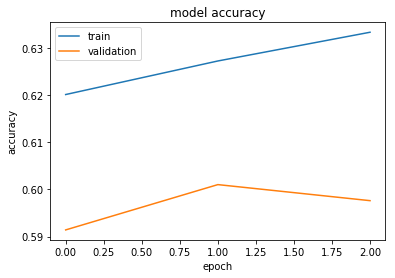

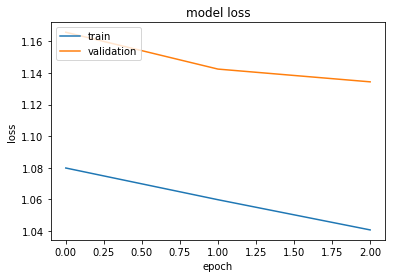

In [24]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Loading and evaluating weights and model from the disk

In [ ]:
def load_model(model_name):
    """
    Arguments: a tring model_name
    Load the model and the wights, returns a loaded model
    """
    # load json and create model
    json_file = open(model_name + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(model_name ".h5")
    print("Loaded model from disk")
    return loaded_model

# #EVALUATE MODEL
# # evaluate loaded model on test data
# lr = 0.00000005
# optimizer = keras.optimizers.Nadam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
# loaded_model.compile(loss=keras.losses.categorical_crossentropy,
#               optimizer= optimizer,
#               metrics=['accuracy'])
# score = loaded_model.evaluate(x_test, y_test_encoded, verbose=0)
# print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [25]:
score = model.evaluate(x_test, y_test_encoded, verbose=0)
# Prediction time
#choose randomly an image from the test set
index = np.random.randint(x_test.shape[0])
x_predict = x_test[index]
x_shape = x_predict.shape

#makes the 3d volume become 4d
x_predict = x_predict.reshape((1, x_predict.shape[0], x_predict.shape[1], x_predict.shape[2]))
y_predict = model.predict_classes(x_predict)
y_predict = int(y_predict.reshape(1))
print("The prediction: ", y_predict, classes[y_predict])
print( "The label: ", y_test[index], classes[int(y_test[index])])
plt.imshow(X_predict.reshape(x_shape))



KeyboardInterrupt: 

## Saving model and weights to disk

Tutorial to save the model and the weights to disk.
https://machinelearningmastery.com/save-load-keras-deep-learning-models/

In [21]:
def serialize_model(model, model_name):
    """
    Arguments: 
    model: the model we sused to train
    model_name - string that
    Saves the model in a file .json and the weights in a .h5 file
    """
    model_json = model_name + ".json"
    model_h5 = model_name + ".h5"
    # serialize model to JSON
    model_json = model.to_json()
    with open(model_name + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(model_name + ".h5")
    print("Saved model to disk")

In [26]:
serialize_model(model, "super_cool_model")

Saved model to disk


## References:
http://adventuresinmachinelearning.com/keras-tutorial-cnn-11-lines/
https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/
https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/

Initialize parameters:
https://keras.io/optimizers/

Optimizers:
https://keras.io/optimizers/

Counting time:  
https://stackoverflow.com/questions/3620943/measuring-elapsed-time-with-the-time-module

Visualizing the data:  
https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

Making predictions:
https://machinelearningmastery.com/how-to-make-classification-and-regression-predictions-for-deep-learning-models-in-keras/

## Problems:
**In exp02**:
Add he-inititializer, use the training set with 45000 examples and the validation set with 5000.
Why change: I think the model is falling at breaking symetry. (it didn't break symetry)

**In exp03**:
keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004.The cost does not get lower on epochs. Possilble problem, gradient vanishing. Solution: ResNet?
**In exp04**: increase number of neurons in the FC layer.
